# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 18: Generalized Linear Models III. Multinomial Logistic Regression. Regularization of MNR. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - parameters
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()
# - rng
rng = np.random.default_rng()
# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

## 1. Multinomial Regression

The Multinomial Regression model is a powerful classification tool. Consider a problem where some outcome variable can result in more than two discrete outcomes. For example, a customer visiting a webshop can end up their visit (a) buying nothing, (b) buying some Product A, or (c) Product B, or (d) Product C, etc. If we have some information about a particular customer's journey through the website (e.g. how much time did they spend on some particular pages, did they visit the webshop before or not, or any other information that customers might have chose to disclose on their sign-up...), we can use it as a set of predictors of customer behavior resulting in any of the (a), (b), (c), (d). We do that by means of a simple extension of the Binomial Logistic Regression that is used to solve for dichotomies: enters the Multinomial Regression model.

### The Model

First, similar to what happens in *dummy coding*, given a set of $K$ possible outcomes we choose one of them as a *baseline*. Thus all results of the Multionomial Regression will be interpreted as effects relative to that baseline outcome category, for example: for a unit increase in predictor $X_1$ what is the change in odds to switch from (a) buying nothing to (b) buying Product A. We are already familiar with this logic, right?

So, consider a set of $K-1$ independent Binary Logistic Models with only one predictor $X$ where the baseline is now referred to as $K$:

$$log\frac{P(Y_i = 1)}{P(Y_i = K)} = \beta_{1,0} + \beta_{1,1}X$$

$$log\frac{P(Y_i = 2)}{P(Y_i = K)} = \beta_{2,0} + \beta_{2,1}X$$

$$log\frac{P(Y_i = K-1)}{P(Y_i = K)} = \beta_{K-1,0} + \beta_{K-1,1}X$$

Obviously, we are introducing a set of new regression coefficients ($\beta_{k,\cdot}$) for each possible value of the outcome $k = 1, 2,.., K-1$. The *log-odds* are on the LHS while the linear model remains on the RHS.

Now we exponentiate the equations to arrive at the expressions for *odds*:

$$\frac{P(Y_i = 1)}{P(Y_i = K)} = e^{\beta_{1,0} + \beta_{1,1}X}$$

$$\frac{P(Y_i = 2)}{P(Y_i = K)} = e^{\beta_{2,0} + \beta_{2,1}X}$$

$$\frac{P(Y_i = K-1)}{P(Y_i = K)} = e^{\beta_{K-1,0} + \beta_{K-1,1}X}$$

And solve for $P(Y_i = 1), P(Y_i = 2),.. P(Y_i = K-1)$:

$$P(Y_i = 1) = P(Y_i = K)e^{\beta_{1,0} + \beta_{1,1}X}$$

$$P(Y_i = 2) = P(Y_i = K)e^{\beta_{2,0} + \beta_{2,1}X}$$

$$P(Y_i = K-1) = P(Y_i = K)e^{\beta_{K-1,0} + \beta_{K-1,1}X}$$

From the fact that all probabilities $P(Y_i = 1), P(Y_i = 2), .., P(Y_i = K)$ must sum to one it can be shown that

$$P(Y_i = K) = \frac{1}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

Because:

(1) $P(Y_i = 1) + P(Y_i = 2) + ... + P(Y_i = K) = 1$, we have

(2) $P(Y_i = K) + P(Y_i = K)e^{\beta_{1,0} + \beta_{1,1}X} + P(Y_i = K)e^{\beta_{2,0} + \beta_{2,1}X} + ... + P(Y_i = K=1)e^{\beta_{K-1,0} + \beta_{K-1,1}X} = 1$ 

(3) and then replace $e^{\beta_{1,0} + \beta_{1,1}X}$ by $l_1$, $e^{\beta_{2,0} + \beta_{2,1}X}$ by $l_2$, and $e^{\beta_{k,0} + \beta_{k,1}X}$ by $l_k$ in the general case, we have

(4) $P(Y_i = K) + P(Y_i = K)e^{l_1} + P(Y_i = K)e^{l_2} + ... + P(Y_i = K-1)e^{l_{K-1}} = 1$

(5) $P(Y_i = K)[1 + e^{l_1} + e^{l_2} + ... + e^{l_{K-1}}] = 1$ so that 

(6) $P(Y_i = K) = \frac{1}{1 + e^{l_1} + e^{l_2} + ... + e^{l_{K-1}}} = \frac{1}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$

It is easy now to derive the expressions for all $K-1$ probabilities of the outcome resulting in a particular class:

$$P(Y_i = 1) = \frac{e^{\beta_{1,0} + \beta_{1,1}X}}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

$$P(Y_i = 2) = \frac{e^{\beta_{2,0} + \beta_{2,1}X}}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

$$P(Y_i = K-1) = \frac{e^{\beta_{K-1,0} + \beta_{K-1,1}X}}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

In [137]:
# - loading the dataset
# - Kaggle: https://www.kaggle.com/datasets/uciml/iris
# - place it in your _data/ directory
iris_data = pd.read_csv(os.path.join(data_dir, 'Iris.csv'), index_col='Id')
iris_data.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


In [3]:
# - counting the instances of each category
iris_data['Species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

In [4]:
# - info on the variables
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


### Target: predict species from all continuous predictors

We use Multinomial Logistic Regression Model to predict the most probable category for the given observation $\textbf{x}$ with features $(x_1, x_2, \ldots, x_k)$. Assume that our target variable $y$ belongs to one of categories from the set $\{1, 2, \ldots, C\}$. In MNR we usually select one category as the referrence category; let that be the category $C$. Then, the probability that the target variable $y$ belongs to category $c = 1,\ldots,C-1$ is calculated via

$$P(y = c) = \frac{e^{\beta^{(c)}_1x_1 + \beta^{(c)}_2x_2 + \cdots + \beta^{(c)}_kx_k + \beta_0}}{1+\sum_{j=1}^{C-1}e^{\beta^{(j)}_1x_1 + \beta^{(j)}_2x_2 + \cdots + \beta^{(j)}_kx_k + \beta_0}},$$

and the probability that it belogns to the referrence category $C$ is 

$$P(y = C) = \frac{1}{1+\sum_{j=1}^{C-1}e^{\beta^{(j)}_1x_1 + \beta^{(j)}_2x_2 + \cdots + \beta^{(j)}_kx_k + \beta_0}},$$

where $\beta^{(j)}_1, \beta^{(j)}_2, \ldots, \beta^{(j)}_k,\ j=1,\ldots,C$ are the model's parameters for predictors and target variable categories, and $n$ is the intercept of the model.

After calculating all the probabilities $P(y = c),\ c=1,\ldots,C$ we predict the target variable as

$$\hat{y} = \textrm{argmax}_{c=1,\ldots,C}P(y=c).$$

The model is estimated by MLE (Maximum Likelihood Estimation). For each category $c$ - except for the referrence $C$, of course - we obtain a set of coefficients. Each model coefficient, in each category, tells us about the $\Delta_{odds}$ in favor of the target category, for a unit change of a predictor, in comparison with the baseline category, and given that everything else is kept constant.

In [5]:
### --- Preparing the variables 

# - feature matrix
X = iris_data.drop(columns='Species')
# - we append a constant column of ones to the feature matrix
X = sm.add_constant(X)
print(X[:10])


# - we impose the ordering to the categories of the target vector; 
# - the first category is the referrence category
cat_type = pd.CategoricalDtype(categories=["Iris-versicolor", 
                                           "Iris-virginica", 
                                           "Iris-setosa"], ordered=True)
y = iris_data['Species'].astype(cat_type)

    const  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
Id                                                                 
1     1.0            5.1           3.5            1.4           0.2
2     1.0            4.9           3.0            1.4           0.2
3     1.0            4.7           3.2            1.3           0.2
4     1.0            4.6           3.1            1.5           0.2
5     1.0            5.0           3.6            1.4           0.2
6     1.0            5.4           3.9            1.7           0.4
7     1.0            4.6           3.4            1.4           0.3
8     1.0            5.0           3.4            1.5           0.2
9     1.0            4.4           2.9            1.4           0.2
10    1.0            4.9           3.1            1.5           0.1


In [6]:
# - fitting the MNR model to the data; 
# - we use the Newton's Conjugate Gradient method as 
# - the optimizer to compute the models coefficients
mnr_model = sm.MNLogit(exog=X, endog=y).fit(method='ncg', maxiter=150)
mnr_model.summary()

Optimization terminated successfully.
         Current function value: 0.039663
         Iterations: 126
         Function evaluations: 127
         Gradient evaluations: 127
         Hessian evaluations: 126


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                Species   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Thu, 04 May 2023   Pseudo R-squ.:                  0.9639
Time:                        23:26:49   Log-Likelihood:                -5.9494
converged:                       True   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 7.056e-64
=======================================================================================
Species=Iris-virginica       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -42.6378     25.707     -1.659      0.097     -93.023       7.748
SepalLengthCm             -2.4650      2.394     -1.030      0.303      -7.158       2.228
SepalWidthCm              -6.6814      4.480     -1.491      0.136     -15.461       2.099
PetalLengthCm              9.4294      4.737      1.990      0.047       0.145      18.714
PetalWidthCm              18.2859      9.743      1.877      0.061      -0.809      37.381
------------------------------------------------------------------------------------------
Species=Iris-setosa       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2477   2830.080      0.000      1.000   -5545.606    5548.102
SepalLengthCm           2.1595    800.555      0.003      0.998   -1566.899    1571.218
SepalWidthCm            6.3676    394.523      0.016      0.987    -766.884     779.619
PetalLengthCm         -10.6759    516.903     -0.021      0.984   -1023.788    1002.436
PetalWidthCm           -5.4912    980.189     -0.006      0.996   -1926.626    1915.644
=======================================================================================
"""

In [7]:
# - confusion matrix for our model and given data; 
# - rows/columns are on par with the ordering of categorical variable
mnr_model.pred_table()

array([[49.,  1.,  0.],
       [ 1., 49.,  0.],
       [ 0.,  0., 50.]])

In [8]:
# - accuracy of the model
correct_classes = np.trace(mnr_model.pred_table())
print(f'Correct observations: {correct_classes}')
num_obs = np.sum(mnr_model.pred_table())
print(f'Total observations: {num_obs}')
print(f'The accuracy of our model: {round(correct_classes/num_obs, 4)}')

Correct observations: 148.0
Total observations: 150.0
The accuracy of our model: 0.9867


In [9]:
# - model's prediction of probabilities; 
# - columns correspond to the ordering of categorical variable
mnr_model.predict()[:10]

array([[9.20967484e-09, 1.42177555e-35, 9.99999991e-01],
       [3.42387722e-07, 2.44370591e-32, 9.99999658e-01],
       [5.07406119e-08, 6.06932699e-34, 9.99999949e-01],
       [1.00687690e-06, 1.98158417e-31, 9.99998993e-01],
       [6.04626221e-09, 6.12291889e-36, 9.99999994e-01],
       [2.78376401e-08, 9.29455175e-34, 9.99999972e-01],
       [8.87535142e-08, 5.70622243e-33, 9.99999911e-01],
       [6.28372828e-08, 6.21641455e-34, 9.99999937e-01],
       [1.90536565e-06, 9.09786880e-31, 9.99998095e-01],
       [3.04189668e-07, 4.59068099e-33, 9.99999696e-01]])

In [10]:
# - model's prediction of categories; 
# - numbers correspond to the ordering of categorical variable
preds = np.argmax(mnr_model.predict(), axis=-1)
preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Multicolinearity in Multinomial Regression

In [11]:
# - Step 1: recode categorical target variable to integer values, 
# - just in order to be able to run a multiple linear regression on the data:
y_code = y.cat.codes
y_code

Id
1      2
2      2
3      2
4      2
5      2
      ..
146    1
147    1
148    1
149    1
150    1
Length: 150, dtype: int8

In [12]:
### --- Step 2: produce a Multiple Linear Regression model for the data 
mnr_model = sm.OLS(exog=X, endog=y_code).fit()
mnr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     48.17
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.02e-25
Time:                        23:26:49   Log-Likelihood:                -119.03
No. Observations:                 150   AIC:                             248.1
Df Residuals:                     145   BIC:                             263.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4405      0.509     -0.866      0.388      -1.446       0.565
SepalLengthCm     0.0872      0.143      0.608      0.544      -0.196       0.371
SepalWidthCm      0.6832      0.149      4.586      0.000       0.389       0.978
PetalLengthCm    -0.4413      0.142     -3.117      0.002      -0.721      -0.161
PetalWidthCm      0.4198      0.235      1.789      0.076      -0.044       0.884
==============================================================================
Omnibus:                       28.857   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.904
Skew:                          -0.222   Prob(JB):                       0.0192
Kurtosis:                       1.966   Cond. No.                         91.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# --- Step 3: compute VIFs for the predictors
predictors = iris_data.columns.drop('Species')
predictors

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

In [14]:
# - appending the columns of ones to the predictors' data
model_frame_predictors = sm.add_constant(iris_data[predictors])

In [15]:
# - computing VIFs
vifs = [variance_inflation_factor(model_frame_predictors.values, i) for i in range(1, len(predictors)+1)]
vifs = np.array(vifs).reshape(1, -1)
pd.DataFrame(vifs, columns=predictors)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,7.103113,2.099039,31.397292,16.141564


### Multinomial Logistic Regression using scikit-learn

Scikit-Learn Documentation

- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [17]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [18]:
# - Preparing the variables 

# - feature matrix
X = iris_data.drop(columns='Species').values

# - scale feature matrix for regularization
# - define standard scaler
scaler = StandardScaler()
# - transform data
scaled = scaler.fit_transform(X)

# - target variable
y = iris_data['Species']

**N.B.** scikit-learn does not implement the referrence category automatically! 

In [19]:
# - Fitting the logistic model to the numerical data
# - scikit-learn does not implement the referrence category automatically 
log_reg = LogisticRegression(solver='newton-cg', 
                             penalty='none')
log_reg.fit(X, y)

LogisticRegression(penalty='none', solver='newton-cg')

In [20]:
# - coefficents of the model; 
# - rows correspond to the order of appearance of categories in the target variable
log_reg.coef_, log_reg.intercept_

(array([[  4.88690435,   7.84898812, -12.84520362,  -6.66561933],
        [ -1.21084317,  -0.58404658,   1.70789901,  -5.81027259],
        [ -3.67606118,  -7.26494154,  11.13730461,  12.47589191]]),
 array([  2.32984794,  20.15404687, -22.48389481]))

In [21]:
# - model's accuracy
round(log_reg.score(X, y), 4)

0.9867

In [22]:
# - predictions
y_pred = log_reg.predict(X)
y_pred[:10]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

In [23]:
# - confusion matrix for the given data
# - rows/columns rows correspond to the 
# - order of appearance of categories in the target variable
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]])

## 2. Regularization of Multinomial Regression

Scikit-Learn Documentation

- [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [24]:
# - loading the dataset
# - UCI ML: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) 
# - (download winequality-red.csv)
# - place it in your _data/ directory
wine_data = pd.read_csv(os.path.join(data_dir, 'winequality-red.csv'), sep=';')
wine_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


### Target: predict wine quality from all the predictors

In [25]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [26]:
predictors = wine_data.columns.drop('quality')
predictors

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [27]:
# - converting 'quality' variable which is numerical into ordered categorical
wine_data['quality'] = wine_data['quality'].astype(pd.CategoricalDtype(ordered=True))
wine_data['quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1599 entries, 0 to 1598
Series name: quality
Non-Null Count  Dtype   
--------------  -----   
1599 non-null   category
dtypes: category(1)
memory usage: 1.9 KB


In [28]:
wine_data['quality'].head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: category
Categories (6, int64): [3 < 4 < 5 < 6 < 7 < 8]

In [29]:
wine_data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [30]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality')

# - scale feature matrix for regularization
# - define standard scaler
scaler = StandardScaler()
# - transform data
scaled = scaler.fit_transform(X)

# - target vector
y = wine_data['quality']

### Regularization of the model coefficients: Ridge (L2) Regularization

Now we are going to use scikit-learn to perform *Regularized* Multinomial Logistic Regression; we'll be using the Ridge Regression. 

The Ridge Regression model is obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_2^2,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_2^2$ is the squared *Frobenius norm* of model parameters matrix $W$:

$$L_2^2 = ||W||_F^2 = \sum_{i=1}^k\sum_{j=1}^K(\beta_i^{(j)})^2;$$

$k$ is the number of predictors, $K$ number of categories of the targert variable, and $\beta_i^{(j)}$ are model parameters. $C$ is the *Regularization (hyper)parameter* and it is the **inverse** of penalization hyperparameter $\alpha$.

In [31]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

**NOTE.**

In [32]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [33]:
### --- Fitting a Ridge MNR Regularized model on the given data, with the regularization parameter C = 250

# - NOTE: LogisticRegression from scikit-learn implements L2 regularization BY DEFAULT
# - so, you actually don't need to pass 'penalty' parameter in order to implement Ridge Regularization
# - if you want to perform MNR without any regularization with scikit-learn, 
# - you need to pass 'penalty=none' parameter

log_reg = LogisticRegression(solver='newton-cg', 
                             penalty='l2', 
                             class_weight='balanced',
                             C=250)
log_reg.fit(X, y)

LogisticRegression(C=250, class_weight='balanced', solver='newton-cg')

In [34]:
# - intercept of the model; entries correspond to the orderdering of the categories in the target variable 
log_reg.intercept_

array([-28.62308159,  15.89850923,   3.76561423,  -3.24895852,
        -0.16191268,  12.36982933])

In [35]:
# - coefficents of the model; rows correspond to the ordering of the categories in the target variable;
# - columns correspond to the predictors
log_reg.coef_

array([[ 6.79146811e-01,  9.80401944e+00,  2.45486058e+00,
         2.67787710e-01,  2.03988871e+01,  1.12618415e-01,
        -7.65427248e-02,  7.26919991e+00,  1.02746698e+01,
        -3.23066934e+00, -2.46990773e+00],
       [-8.98924719e-02,  2.04744756e+00,  2.55349919e-01,
         1.02393524e-01,  1.02055335e+01, -4.97650056e-02,
         1.82696504e-02, -1.91751872e+01,  2.47413459e+00,
        -2.44858774e+00, -3.67050329e-01],
       [-1.27468343e-01, -1.45765057e+00, -1.41088049e+00,
        -4.28888032e-02,  8.69824882e+00, -3.55916508e-02,
         3.58239853e-02,  7.21179025e+00, -2.97557826e-01,
        -2.61418402e+00, -6.08109750e-01],
       [-5.47780654e-02, -3.56111059e+00, -2.26103484e+00,
        -6.76196076e-02,  4.26194708e+00, -1.70123060e-02,
         2.07884819e-02,  7.76098367e+00, -1.03605205e+00,
        -2.84751055e-01,  2.74477447e-01],
       [ 4.70384856e-02, -5.73632474e+00, -1.64360192e+00,
        -1.22908720e-02, -3.84951012e+00, -1.62463236e-02,
  

In [36]:
# - accuracy of Ridge Regularization
log_reg.score(X, y)

0.4277673545966229

F1 score

In [37]:
y_hat = log_reg.predict(X)
y_hat

array([4, 5, 5, ..., 6, 4, 6])

In [38]:
np.round(f1_score(y, y_hat, average='weighted'), 4)

0.4741

In [39]:
### --- Varying the regularization parameter for the Ridge Regularized Model
n_Cs = 100
Cs = np.linspace(1e-2, 500, n_Cs)

l2_coefs = []
accuracies = []
frob_norms_matrix = []
w_f1_scores = []
for C in Cs:
    
    # - fitting a Ridge Regularization
    ridge = LogisticRegression(solver='newton-cg', 
                               C=C, 
                               class_weight='balanced',
                               max_iter=1000,
                               n_jobs = -1)
    ridge.fit(X, y)
    
    # - squared L2 norm of model coefficients vectors for each category
    l2_c = np.linalg.norm(ridge.coef_, ord=2, axis=0)**2
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - squared Frobenius norm of model coefficient matrix
    frob = np.linalg.norm(ridge.coef_, ord=2)**2

    # - predict 
    y_hat = ridge.predict(X)
    
    # - weighted F1 score
    f1 = f1_score(y, y_hat, average='weighted')
    
    l2_coefs.append(l2_c)
    accuracies.append(acc)
    frob_norms_matrix.append(frob)
    w_f1_scores.append(f1)

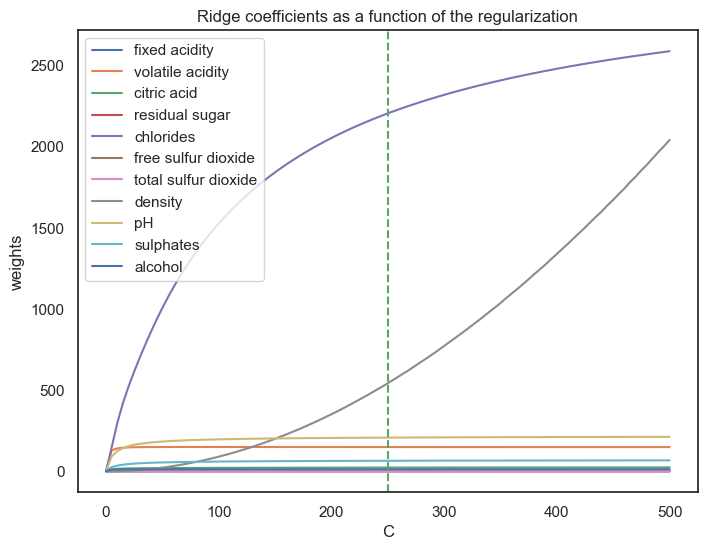

In [40]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l2_coefs)
ax.axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
plt.xlabel("C")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

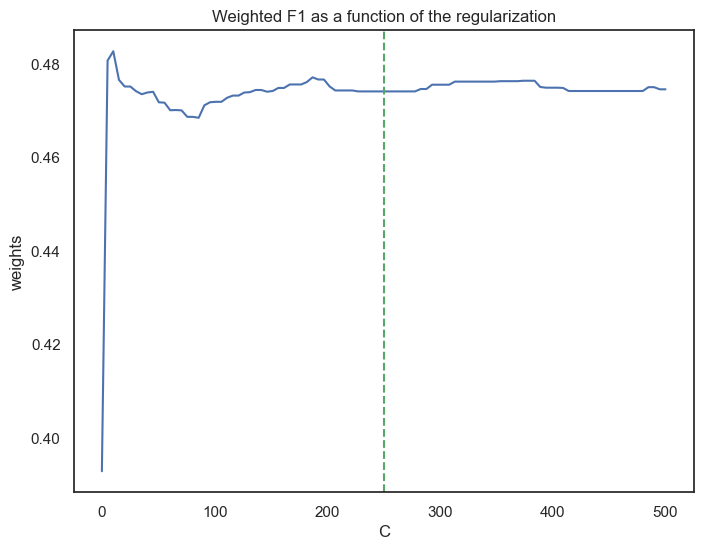

In [41]:
### --- Plotting the dependence of weighted F1 vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, w_f1_scores)
ax.axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
plt.xlabel("C")
plt.ylabel("weights")
plt.title("Weighted F1 as a function of the regularization")
plt.axis("tight")
plt.show()

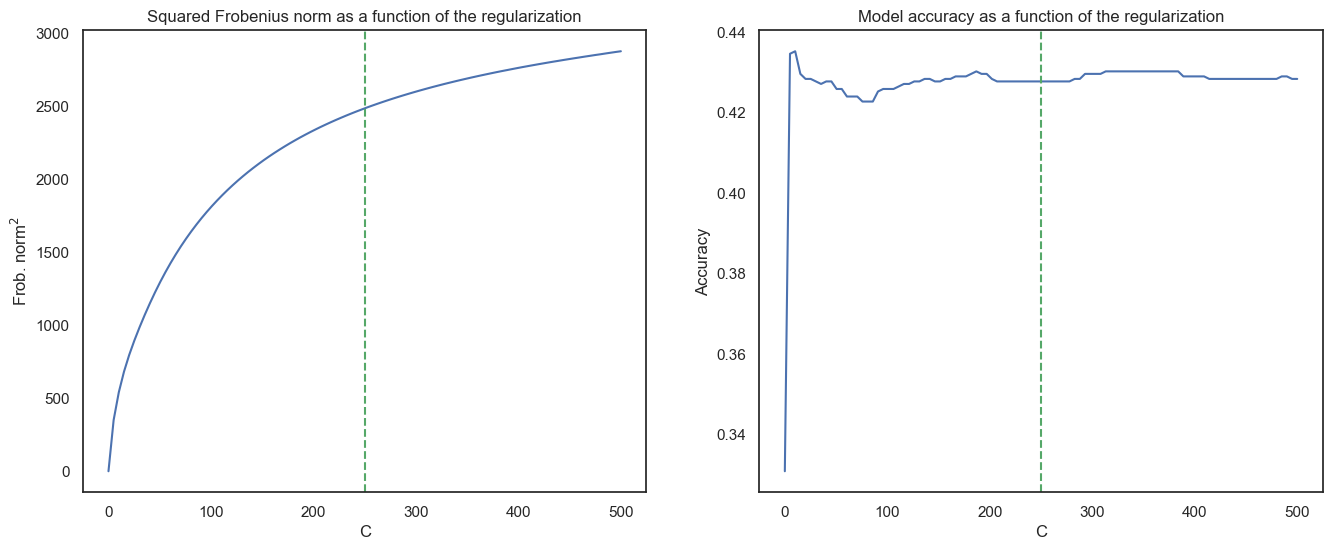

In [42]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# - squared Frobenius vs. C
ax[0].plot(Cs, frob_norms_matrix)
ax[0].axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
ax[0].set_xlabel("C")
ax[0].set_ylabel("Frob. norm$^2$")
ax[0].set_title("Squared Frobenius norm as a function of the regularization")
ax[0].axis("tight")

# - accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].axvline(x=250, c='g', ls='--') # green line
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

In [43]:
bestC = Cs[np.argmax(w_f1_scores)]
bestC

10.11080808080808

In [44]:
### --- Fitting an assumed approximation of the best Ridge Regularized model
ridge_best = LogisticRegression(C=bestC, 
                                class_weight='balanced',
                                solver='newton-cg',
                                max_iter=1000,
                                n_jobs = -1)
ridge_best.fit(X, y)

LogisticRegression(C=10.11080808080808, class_weight='balanced', max_iter=1000,
                   n_jobs=-1, solver='newton-cg')

In [45]:
ridge_best.intercept_

array([-13.78350318,  -0.56253942,  10.95872022,   2.79637835,
        -5.80486825,   6.39581228])

In [46]:
ridge_best.coef_

array([[ 5.37907290e-01,  9.46308573e+00,  2.59557906e+00,
         2.47960564e-01,  9.87225903e+00,  1.18280369e-01,
        -7.82607522e-02,  3.24469558e-01,  7.82196907e+00,
        -1.84004221e+00, -2.28901830e+00],
       [-1.43643574e-01,  2.34124445e+00,  6.54018957e-01,
         1.06703263e-01,  3.23145611e+00, -4.38832447e-02,
         1.54174176e-02, -7.46487607e-01,  1.98215862e+00,
        -1.92060716e+00, -3.68630949e-01],
       [-1.39006899e-01, -9.55294645e-01, -9.35209990e-01,
        -1.98798956e-02,  2.54253823e+00, -2.99339769e-02,
         3.29344102e-02,  3.20397322e-01, -3.75720041e-01,
        -2.18753852e+00, -6.43574384e-01],
       [-2.84758516e-02, -3.09086501e+00, -1.88151010e+00,
        -4.68053383e-02,  6.21142473e-01, -1.39615331e-02,
         1.88849285e-02,  3.40974205e-01, -6.74380974e-01,
        -4.07287983e-01,  2.46848159e-01],
       [ 1.04956955e-01, -5.57760047e+00, -1.61366032e+00,
        -1.71832887e-02, -2.97757223e+00, -1.87121636e-02,
  

In [47]:
# - accuracy of our model
ridge_best.score(X, y)

0.4352720450281426

In [48]:
# - F1
# - predict 
y_hat = ridge_best.predict(X)
# - weighted F1 score
f1 = f1_score(y, y_hat, average='weighted')
f1

0.48269820510557326

### LASSO (L1) Regularization

*LASSO* is another way to regularize MNR model. It's obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_1,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_1$ is the $L_1$ norm of model parameters matrix $W$:

$$L_1 = ||W||_1 = \sum_{i=1}^k\sum_{j=1}^K|\beta_i^{(j)}|.$$

$C$ is, of course regularization hyperparameter.

In [52]:
### --- Varying the penalization parameter for the LASSO Regularized Model
n_Cs = 100
Cs = np.linspace(1e-2, 500, n_Cs)

l1_coefs = []
accuracies = []
l1_norms_matrix = []
w_f1_scores = []
for C in Cs:
    # - fitting a LASSO Regularization
    # - when using 'saga' solver, we need to set multi_class='multinomial' argument explicitly
    lasso = LogisticRegression(solver='saga', 
                               multi_class='multinomial', 
                               penalty='l1', 
                               C=C, 
                               class_weight='balanced',
                               max_iter=10**5,
                               n_jobs=-1)
    lasso.fit(X, y)
    
    # - L1 norm of model coefficients vectors for each category
    l1_c = np.linalg.norm(lasso.coef_, ord=1, axis=0)
    
    # - accuracy of a fitted Regularized Model
    acc = lasso.score(X, y)
    
    # - L1 norm of model coefficient matrix
    l1_m = np.linalg.norm(lasso.coef_, ord=1)

    # - predict 
    y_hat = lasso.predict(X)
    
    # - weighted F1 score
    f1 = f1_score(y, y_hat, average='weighted')
    
    l1_coefs.append(l1_c)
    accuracies.append(acc)
    l1_norms_matrix.append(l1_m)
    w_f1_scores.append(f1)

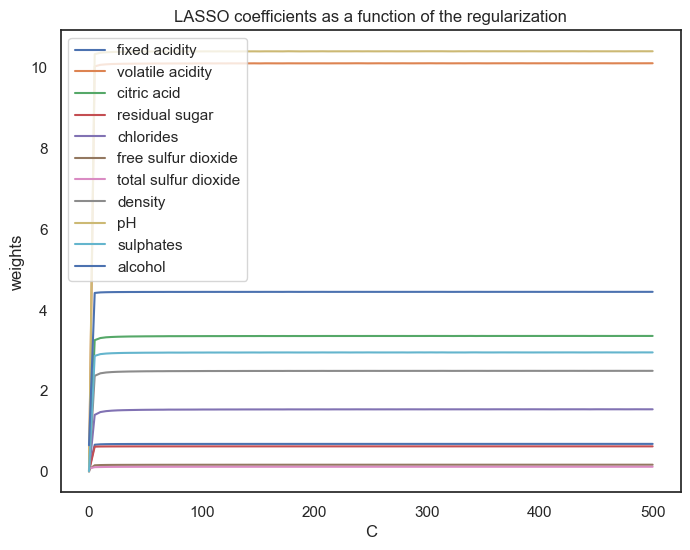

In [53]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l1_coefs)
plt.xlabel("C")
plt.ylabel("weights")
plt.title("LASSO coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

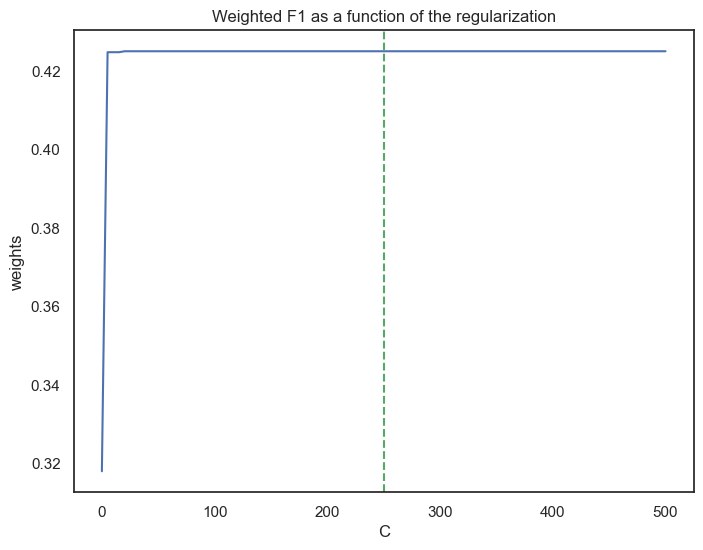

In [54]:
### --- Plotting the dependence of weighted F1 vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, w_f1_scores)
ax.axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
plt.xlabel("C")
plt.ylabel("weights")
plt.title("Weighted F1 as a function of the regularization")
plt.axis("tight")
plt.show()

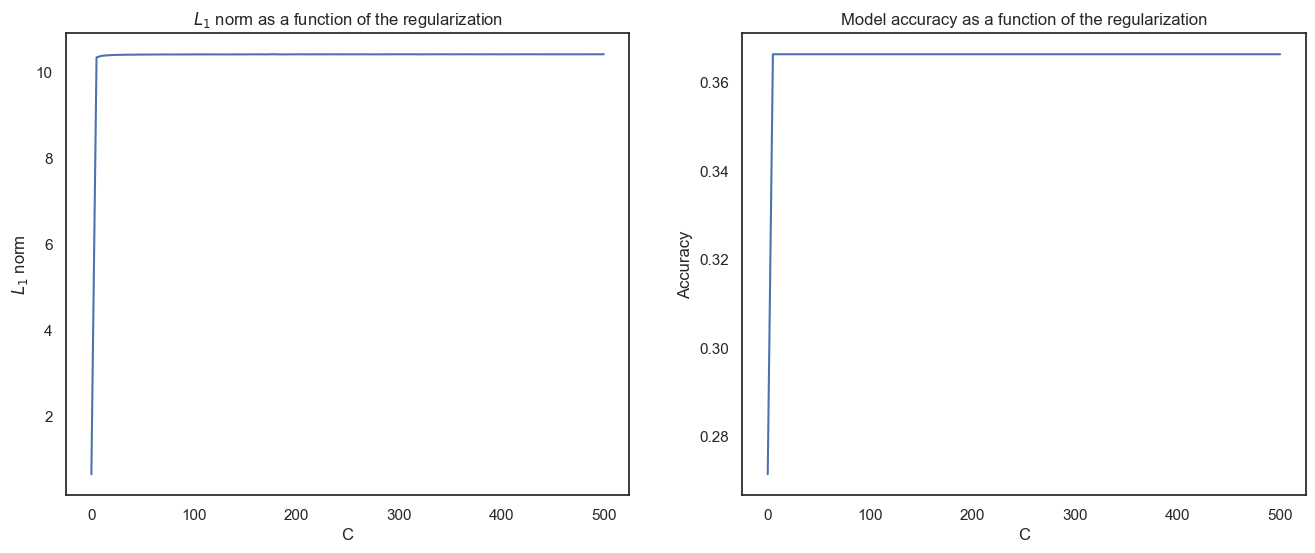

In [55]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - L1-norm vs. C
ax[0].plot(Cs, l1_norms_matrix)
ax[0].set_xlabel("C")
ax[0].set_ylabel("$L_1$ norm")
ax[0].set_title("$L_1$ norm as a function of the regularization")
ax[0].axis("tight")

# - Model accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

In [56]:
bestC = Cs[np.argmax(w_f1_scores)]
bestC

20.211616161616163

In [57]:
# - fitting an assumed best approximation for C
lasso_best = LogisticRegression(C=bestC, 
                                solver='saga', 
                                penalty='l1', 
                                class_weight='balanced',
                                n_jobs=-1,
                                multi_class='multinomial', 
                                max_iter=10**5)
lasso_best.fit(X, y)

LogisticRegression(C=20.211616161616163, class_weight='balanced',
                   max_iter=100000, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', solver='saga')

In [58]:
lasso_best.intercept_

array([ 0.35541507,  0.28113911,  0.55282501,  0.05054272, -0.53959831,
       -0.7003236 ])

In [59]:
lasso_best.coef_

array([[ 3.35377762e-01,  3.98821024e+00, -5.12136202e-01,
         1.91361089e-01,  6.27092190e-01,  8.28082708e-02,
        -5.73615706e-02,  3.57805603e-01,  2.36129633e+00,
        -4.66053564e-01, -1.28438065e+00],
       [-1.13322957e-01,  1.06176231e+00, -4.49292253e-01,
         1.14640540e-01,  4.23349965e-02, -3.38706086e-02,
         1.02137985e-02,  2.71057831e-01,  1.29513489e+00,
        -4.97737433e-01, -3.67718367e-01],
       [ 6.65889901e-03, -1.56375113e-01, -4.86620683e-01,
         5.51724280e-03,  8.16623716e-02, -2.03960151e-02,
         2.69479093e-02,  5.47707553e-01,  1.47179863e+00,
        -4.71061437e-01, -5.67696676e-01],
       [-3.83197472e-02, -1.20332136e+00, -2.10570844e-01,
        -2.17515126e-02, -1.00447341e-01,  7.44040112e-04,
         8.76515483e-03,  4.72155862e-02,  6.26384756e-02,
        -2.66739160e-02,  1.02604472e-01],
       [-3.95558392e-02, -2.21781148e+00,  5.06307245e-01,
        -2.08646546e-02, -2.73544346e-01, -4.63505082e-03,
  

In [60]:
lasso_best.score(X, y)

0.36647904940587867

## 3. Cross-Validation of Multinomial Regression

In order to find the most optimal penalization hyperparameter we may use *cross-validation* across the 'grid' of hyperparameters, fitting a model for every $C$ in the grid, and then choosing the best perfoming-one (i.e. with the highest accuracy).

K-fold cross-validation (CV) is a common technique used to estimate the performance of a predictive model. In k-fold CV, the dataset is randomly split into k equally sized folds, and the model is trained and evaluated k times.

The steps of k-fold CV can be summarized as follows:

- Shuffle the dataset randomly.
- Split the dataset into k equally sized folds.
- For each fold:
   - Use the current fold as the validation set.
   - Use the remaining k-1 folds as the training set.
   - Train the model on the training set and evaluate its performance on the validation set.
Calculate the average performance of the model across all k iterations.

K-fold CV is useful because it addresses some of the limitations of other cross-validation methods. For example, it is more computationally efficient than LOOCV, as it only requires fitting the model k times, rather than n times. K-fold CV can also help to reduce overfitting compared to simpler methods like hold-out validation, as it allows the model to be trained and evaluated on multiple subsets of the data.

The value of k is typically chosen to balance the trade-off between bias and variance in the performance estimate. Common choices for k include 5 and 10, but other values can also be used. It's worth noting that larger values of k will result in smaller bias but higher variance in the performance estimate, while smaller values of k will result in higher bias but lower variance.

Overall, k-fold CV is a widely used technique for estimating the performance of a predictive model and can be a useful tool for model selection and hyperparameter tuning.

### CV for Ridge (L2) Regularization

Scikit-Learn Documentation

- [sklearn.linear_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

In [61]:
from sklearn.linear_model import LogisticRegressionCV

# - Performing the cross-validation across 10 
# - log-distributed values of C in the [10^(-4), 10^4] interval
ridgeCV = LogisticRegressionCV(Cs=10, 
                               solver='newton-cg',
                               class_weight='balanced', 
                               multi_class='multinomial', 
                               max_iter=1000,
                               n_jobs=-1)
ridgeCV.fit(X, y)

LogisticRegressionCV(class_weight='balanced', max_iter=1000,
                     multi_class='multinomial', n_jobs=-1, solver='newton-cg')

In [62]:
# - regularization hyperparameters for the best model
# - note that we do not obtain a single C, but a set of regularization hyperparameters
# - each entry corresponds to the best regularization value for a given category
ridgeCV.C_

array([10000., 10000., 10000., 10000., 10000., 10000.])

In [63]:
ridgeCV.intercept_

array([-168.28174896,  333.33552259, -106.10522665, -116.72382502,
         54.66318924,    3.1120888 ])

In [64]:
ridgeCV.coef_

array([[ 5.62787463e-01,  9.89114504e+00,  2.65358962e+00,
         1.88251192e-01,  2.33355182e+01,  1.19185627e-01,
        -7.92758424e-02,  1.47781738e+02,  1.03694935e+01,
        -3.84043939e+00, -2.43188649e+00],
       [ 2.21549464e-01,  2.33078377e+00,  1.57650297e-01,
         2.34476356e-01,  1.21702888e+01, -5.65987457e-02,
         2.04891041e-02, -3.43238691e+02,  3.91446428e+00,
        -1.91369666e+00, -6.26694646e-01],
       [-2.30699114e-01, -1.79499484e+00, -1.63476382e+00,
        -8.43510576e-02,  1.05166596e+01, -3.65287834e-02,
         3.69824993e-02,  1.19721488e+02, -9.20278286e-01,
        -2.90693485e+00, -5.05389326e-01],
       [-1.58724105e-01, -3.94756356e+00, -2.51905349e+00,
        -1.11324784e-01,  5.37770279e+00, -1.78231866e-02,
         2.18159128e-02,  1.23926439e+02, -1.70574620e+00,
        -4.10459141e-01,  3.89120276e-01],
       [ 7.66811924e-02, -5.64833637e+00, -1.56579875e+00,
         1.88440160e-02, -3.17140800e+00, -1.74754453e-02,
  

In [65]:
# - accuracy of the model obtained through the cross-validation
ridgeCV.score(X, y)

0.44090056285178236

In [66]:
confusion_matrix(y, ridgeCV.predict(X))

array([[  7,   3,   0,   0,   0,   0],
       [ 12,  24,   9,   6,   1,   1],
       [ 61, 112, 361, 102,  32,  13],
       [ 21,  78, 135, 213, 123,  68],
       [  0,  14,   6,  32,  87,  60],
       [  0,   0,   0,   0,   5,  13]])

### CV for LASSO (L1) Regularization

In [67]:
# - Performing the cross-validation across 10 
# - log-distributed values of C in the [10^(-4), 10^4] interval
lassoCV = LogisticRegressionCV(Cs=10, 
                               solver='saga', 
                               penalty='l1', 
                               class_weight='balanced',
                               n_jobs=-1,
                               multi_class='multinomial', 
                               max_iter=10**5)
lassoCV.fit(X, y)

LogisticRegressionCV(class_weight='balanced', max_iter=100000,
                     multi_class='multinomial', n_jobs=-1, penalty='l1',
                     solver='saga')

In [68]:
# - regularization values obtained through the cross-validation
lassoCV.C_

array([21.5443469, 21.5443469, 21.5443469, 21.5443469, 21.5443469,
       21.5443469])

In [69]:
lassoCV.intercept_

array([ 1.69079594,  1.08803195,  0.70933785,  0.03565816, -1.06247137,
       -2.46135253])

In [70]:
lassoCV.coef_

array([[ 2.98031972e-01,  4.19288133e+00, -8.43577859e-02,
         1.91663220e-01,  2.25174348e-01,  8.80761077e-02,
        -6.21851478e-02,  3.32714734e-02,  1.54301101e+00,
        -1.40532849e-01, -1.09610566e+00],
       [-1.26698705e-01,  1.10595636e+00, -2.77930520e-01,
         1.19109320e-01,  5.02237485e-03, -2.90613757e-02,
         5.52903588e-03,  2.02111103e-02,  8.38977198e-01,
        -3.44434201e-01, -2.55242322e-01],
       [ 7.05926166e-03, -2.54213326e-02, -2.57161886e-01,
         8.29935128e-03,  1.37783158e-02, -1.55958882e-02,
         2.24658523e-02,  2.28180963e-01,  1.10750886e+00,
        -2.86252613e-01, -4.35044382e-01],
       [-3.06544844e-02, -8.96441458e-01, -6.52940522e-02,
        -1.76789166e-02, -2.59901706e-02,  5.70923391e-03,
         4.28081465e-03, -5.48052749e-03, -1.57196300e-01,
        -3.28479430e-02,  1.76355264e-01],
       [ 5.65115504e-03, -2.07035395e+00,  1.96103609e-01,
        -1.10270873e-02, -4.93694567e-02, -8.83658584e-04,
  

In [71]:
# - accuracy of the model obtained through the cross-validation
lassoCV.score(X, y)

0.3545966228893058

### CV for Elastic-Net Regularization

Both Ridge and LASSO Regularizations are a part of a more general *Elastic-net* Regularization, obtaned by minimizing the function 

$$-C\cdot LL + \rho L_1 + \frac{1 - \rho}{2}L_2^2$$

where $\rho\in[0,1]$ is yet another hyperparameter, called *$L_1$-ratio*. For $\rho = 0$ one recovers Ridge Regularization, and for $\rho = 1$ LASSO Regularization.

Since there are two hyperparameters to tune, here we will perform cross-validation for each one, in parallel. 

We make a grid of values for hyperparameters $\rho$ and $C$. For every value of $\rho$ we perform a *k-fold cross-validation*: we split the data in $k$ *folds*, i.e. subsets. Then we select all but one fold to be the *test folds*; all the remaining folds are *train folds*. We fit the model on train folds, and evaluate the performance on the test fold, as an indicator of how it handles the unseen data. After this, we a new fold is chosen as the test fold, while the previous test fold becomes another train fold; we train and evaluate the model in this new setting. We repeat this procedure $k$ times and obtain $k$ different models. We select a combination of hyperparameters which performed the best. 

Note that we will not use values 0 and 1 for $\rho$, as this would lead to *Ridge* and *LASSO* regularization, respectivelly.

First, we preform $k$-fold CV only for hyperparameter $C$, while keeping $\rho = 0.5$ fixed. 

In [73]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
# - and one fixed value for \rho = 0.5; we perform 5-fold CV
elNetCV = LogisticRegressionCV(penalty='elasticnet', 
                               Cs=5, 
                               l1_ratios=[.5], 
                               solver='saga', 
                               n_jobs=-1,
                               class_weight='balanced',
                               multi_class='multinomial', 
                               max_iter=10**5, 
                               cv=5)
elNetCV.fit(X, y)

LogisticRegressionCV(Cs=5, class_weight='balanced', cv=5, l1_ratios=[0.5],
                     max_iter=100000, multi_class='multinomial', n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [74]:
elNetCV.C_

array([1., 1., 1., 1., 1., 1.])

In [75]:
elNetCV.score(X, y)

0.36460287679799874

Now we perform $k$-fold CV for both hyperparameters $C$ and $\rho$ in parallel. 

In [95]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
# - and \rho selects value from the grid

rhos = np.array([0., 0.01, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4, 
                 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9,
                 0.95, 0.99, 1.])

elNetCV = LogisticRegressionCV(penalty='elasticnet', 
                               Cs=30, 
                               l1_ratios=rhos, 
                               class_weight='balanced',
                               n_jobs=-1,
                               solver='saga', 
                               multi_class='multinomial',
                               max_iter=10**4, 
                               cv=5)
elNetCV.fit(X, y)

LogisticRegressionCV(Cs=30, class_weight='balanced', cv=5,
                     l1_ratios=array([0.  , 0.01, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45,
       0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.99,
       1.  ]),
                     max_iter=10000, multi_class='multinomial', n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [96]:
elNetCV.C_

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001])

In [97]:
elNetCV.l1_ratio_

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [98]:
elNetCV.score(X, y)

0.2851782363977486

In [99]:
# - F1
# - predict 
y_hat = elNetCV.predict(X)
# - weighted F1 score
f1 = f1_score(y, y_hat, average='weighted')
f1

0.250765210640013

### Leave-Out-One Cross-Validation (LOOCV) for Multiple Linear Regression

LOOCV (Leave-One-Out Cross-Validation) is a cross-validation method for estimating the performance of a predictive model. The main idea behind LOOCV is to split the dataset into n subsets, where n is the number of observations in the dataset. For each iteration, one observation is left out to serve as the validation set, and the model is trained on the remaining n-1 observations. This process is repeated n times, with each observation being left out once, and the performance of the model is evaluated on each validation set.

The steps of LOOCV can be summarized as follows:

For each observation in the dataset:

- Use that observation as the validation set
- Train the model on the remaining n-1 observations
- Evaluate the performance of the model on the validation set

and then calculate the average performance of the model across all n iterations

LOOCV has several advantages over other cross-validation methods. First, it maximizes the use of the available data for training the model, as all but one observation are used for each training iteration. Second, it provides an unbiased estimate of the model's performance on new, unseen data, as each observation serves as a validation set exactly once. Finally, LOOCV works well for small datasets, as it is not subject to the same sampling variability as other cross-validation methods.

However, LOOCV can also be computationally expensive, especially for large datasets, as it requires fitting the model n times.

Scikit-Learn Documentation

- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- [sklearn.model_selection.LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html)
- [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [117]:
data_set = pd.read_csv(os.path.join(data_dir, 'kc_house_data.csv'))
data_set = data_set.sample(n=1000, random_state=42)
print(data_set.shape)
data_set.head(10)

(500, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
735,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
2830,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
4106,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
16218,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
19964,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
1227,1761300310,20140827T000000,211000.0,4,2.00,1710,8288,1.5,0,0,...,7,1710,0,1970,0,98031,47.3947,-122.174,1710,7200
18849,7732410120,20140819T000000,790000.0,4,2.50,2690,8036,2.0,0,0,...,9,2690,0,1987,0,98007,47.6596,-122.144,2420,8087
19369,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,0,...,7,1350,450,1970,0,98199,47.6599,-122.396,1920,4400
20164,291310170,20140804T000000,384500.0,3,2.50,1600,2610,2.0,0,0,...,8,1600,0,2005,0,98027,47.5344,-122.068,1445,1288
7139,4232901990,20140516T000000,605000.0,2,1.00,910,3600,1.0,0,0,...,7,910,0,1909,0,98119,47.6341,-122.361,1720,3600


In [118]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 735 to 15676
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             500 non-null    int64  
 1   date           500 non-null    object 
 2   price          500 non-null    float64
 3   bedrooms       500 non-null    int64  
 4   bathrooms      500 non-null    float64
 5   sqft_living    500 non-null    int64  
 6   sqft_lot       500 non-null    int64  
 7   floors         500 non-null    float64
 8   waterfront     500 non-null    int64  
 9   view           500 non-null    int64  
 10  condition      500 non-null    int64  
 11  grade          500 non-null    int64  
 12  sqft_above     500 non-null    int64  
 13  sqft_basement  500 non-null    int64  
 14  yr_built       500 non-null    int64  
 15  yr_renovated   500 non-null    int64  
 16  zipcode        500 non-null    int64  
 17  lat            500 non-null    float64
 18  long  

In [119]:
# - we remove some redundant or problematic predictors
model_frame = data_set.drop(columns = ['id', 'lat', 'long', 'date', 'yr_renovated'])
model_frame.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
735,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,98058,2390,7700
2830,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,98115,2370,6283
4106,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,98006,3710,9685
16218,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,98034,4050,14226
19964,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,98052,2250,4050


In [120]:
# - we separate categorical from the numerical and binary predictors
categorical_df = model_frame[['zipcode', 'view']]
numerical_df = model_frame.drop(columns = ['zipcode', 'view'])

In [121]:
# - number of zipcode categories
len(categorical_df['zipcode'].unique())

69

In [122]:
# - view categories
categorical_df['view'].unique()

array([0, 2, 3, 4, 1])

In [123]:
### --- Encoding the categorical variables
from sklearn.preprocessing import OneHotEncoder

# - for each categorical variables we employ Dummy Encoding
# - we take the value appearing the first as the reference category

# - encoding the 'view' variable
enc_view = OneHotEncoder(drop='first', sparse=False)
dummy_view = enc_view.fit_transform(categorical_df['view'].values.reshape(-1, 1))

# - encoding the 'zipcode' variable
enc_zipcode = OneHotEncoder(drop='first', sparse=False)
dummy_zipcode = enc_zipcode.fit_transform(categorical_df['zipcode'].values.reshape(-1, 1))

# - concatenating encoded variables into a single binary matrix
# - it has 73 columns: 69 (i.e. 70-1) for the 'zipcode', and 4 (5-1) for the 'view'
X0 = np.concatenate((dummy_view, dummy_zipcode), axis=-1)
X0.shape

(500, 72)

In [124]:
### --- Constructing the feature matrix and the target vector

# - dropping the dependent (numerical) 'price' variable
X1 = numerical_df.drop(columns='price').values

# - conncatenating the encoded variables matrix with the matrix of numerical variables values
X = np.concatenate((X0, X1), axis=-1)
print(X.shape)

# - standardize X
# - define standard scaler
scaler = StandardScaler()
# - transform data
scaled = scaler.fit_transform(X)

# - target vector values
y = numerical_df['price'].values

(500, 85)


Use [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) to score the LOOCV model.

The Mean Absolute Error (MAE) can be defined mathematically using the following equation:

$$
MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

where $n$ is the number of samples, $y_i$ is the true value of the $i$-th sample, and $\hat{y}_i$ is the predicted value of the $i$-th sample. The absolute difference between the true and predicted values, $|y_i - \hat{y}_i|$, is taken for each sample, and the average of these absolute differences is calculated to obtain the MAE. 

The MAE measures the average magnitude of the errors between the predicted and true values, and is commonly used as a metric for evaluating the performance of regression models. The MAE is expressed in the same units as the original data, which makes it easy to interpret and compare across different models or datasets.

In [136]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression

# Create a linear regression object
lr = LinearRegression()

# Create a LOOCV object
loo = LeaveOneOut()

# Fit and score the model using LOOCV
scores = cross_val_score(lr, 
                         X, y, 
                         cv=loo, 
                         scoring="neg_mean_absolute_error")

# Calculate the Mean MAE across all validation sets
mean_score = -scores.mean()
print("Mean MAE: {:.2f}".format(mean_score))

Mean MAE: 8788761.09


### Further Reading

- [Multinomial logistic regression, From Wikipedia The Free Encyclopedia](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)
- [A Gentle Introduction to k-fold Cross-Validation, by Jason Brownlee](https://machinelearningmastery.com/k-fold-cross-validation/)
- [LOOCV for Evaluating Machine Learning Algorithms, by Jason Brownlee ](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/)
- [Mean absolute error, From Wikipedia The Free Encyclopedia](https://en.wikipedia.org/wiki/Mean_absolute_error)

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>